<a href="https://colab.research.google.com/github/bachvu98/Policy-NLP/blob/master/Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
import time
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from os import listdir
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from lxml import etree, html
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
segments = pd.read_csv('/content/drive/My Drive/OPP-115/OPP-115/segment_processed.csv',index_col=0)
segments.head()

,Policy UID,segment_id,category_name,segments
0,20,0,Other,privacy policy effective january atlantic mont...
1,20,1,Other,privacy policy apply site maintained company o...
2,20,2,Policy Change,visiting site accepting practice described pri...
3,20,3,First Party Collection/Use,information collected collect two basic type i...
4,20,4,First Party Collection/Use,personally identifiable information general ma...


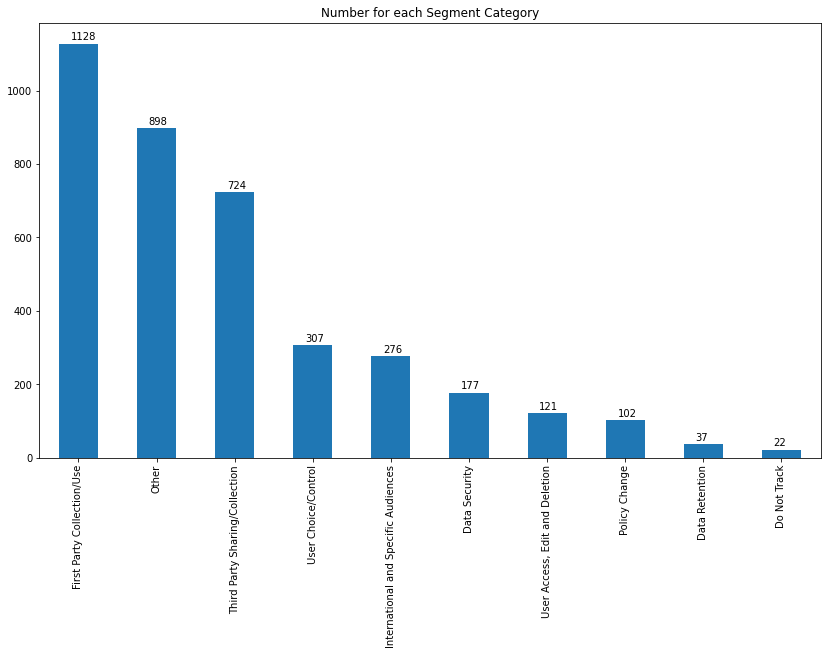

In [3]:
ax = segments['category_name'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Segment Category")

for index, value in enumerate(segments['category_name'].value_counts()):
    ax.text(index-0.1, value+10, "{}".format(value))

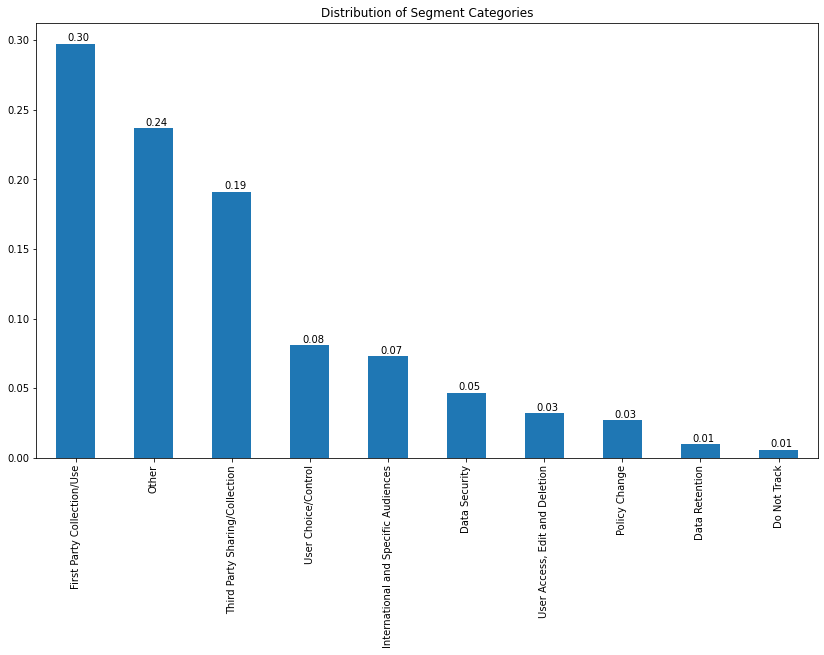

In [ ]:
ax = segments['category_name'].value_counts(normalize=True).plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Segment Categories")

for index, value in enumerate(segments['category_name'].value_counts(normalize=True)):
    ax.text(index-0.1, value+0.002, "{:.2f}".format(value))

In [4]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer("english", ngram_range=(1,2), min_df=5, max_df=0.7, use_idf=True)
# fit the vectorizer using the text data
tfid = tfid_vectorizer.fit(segments['segments'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

tfid_matrix = tfid_vectorizer.transform(segments['segments']).todense()
feature_names = tfid_vectorizer.get_feature_names()

# store the tf-idf array into pandas dataframe
df = pd.DataFrame(tfid_matrix, columns=feature_names)
df['output'] = segments['category_name']
df

,aaa,abide,ability,ability accept,ability access,abita,abitacom,able,able access,able identify,able provide,able take,able use,absolute,absolute security,abuse,acc,accept,accept change,accept cooky,accept request,acceptance,acceptance privacy,accepted,accepting,accepting new,accepting practice,access,access account,access certain,access change,access contact,access control,access cooky,access correct,access correction,access database,access disclosure,access enforcement,access information,...,word,work,work behalf,working,world,worldnowcom,would,would like,write,write kaleida,write privacy,writing,written,written authorization,written consent,written request,wwwaboutadsinfo,wwwaboutadsinfochoices,wwwexportgovsafeharbor,wwwnetworkadvertisingorgmanagingoptoutasp,yahoo,yahoo ad,yahoo also,year,year age,year free,year old,yet,york,york ny,york time,young,youtube,zacks,zacks investment,zackscom,zip,zip code,zone,output
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075825,0.11059,0.0,0.0,0.0,0.0,0.0,0.091806,0.0,0.105672,0.046098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Policy Change
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,First Party Collection/Use
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,First Party Collection/Use
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.060860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
3788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136284,0.173288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
3789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,

In [5]:
#Split data using 30%/70% split
segments_train, segments_test, targets_train, targets_test = train_test_split(df[feature_names], df['output'], test_size=0.3, random_state=0)

In [6]:
targets_test.value_counts()

First Party Collection/Use              333
Other                                   264
Third Party Sharing/Collection          229
User Choice/Control                      90
International and Specific Audiences     79
User Access, Edit and Deletion           49
Data Security                            44
Policy Change                            27
Data Retention                           14
Do Not Track                              9
Name: output, dtype: int64

In [27]:
alpha_list = np.linspace(0.1,3,30)
alpha_list = np.around(alpha_list, decimals=4)
alpha_list

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

In [28]:
kf = KFold(n_splits=5, random_state=0, shuffle=False)
params = {'C': alpha_list,
          }

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [43]:
classifier = LinearSVC(random_state=0, class_weight='balanced')
cross_val_score(classifier, segments_train, targets_train, cv=kf)

array([0.7645951 , 0.74764595, 0.75706215, 0.77777778, 0.75849057])

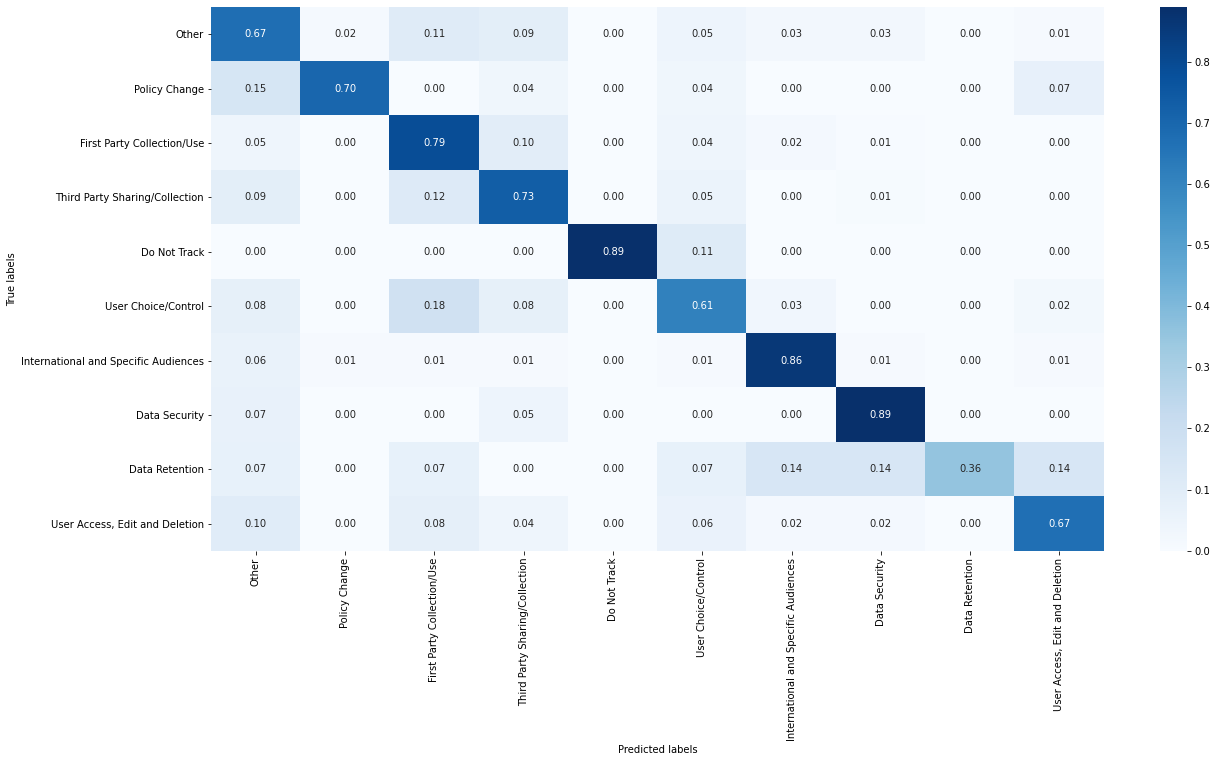

                                      precision    recall  f1-score   support

                      Data Retention       0.83      0.36      0.50        14
                       Data Security       0.72      0.89      0.80        44
                        Do Not Track       1.00      0.89      0.94         9
          First Party Collection/Use       0.77      0.79      0.78       333
International and Specific Audiences       0.78      0.86      0.82        79
                               Other       0.74      0.67      0.71       264
                       Policy Change       0.79      0.70      0.75        27
      Third Party Sharing/Collection       0.71      0.73      0.72       229
      User Access, Edit and Deletion       0.77      0.67      0.72        49
                 User Choice/Control       0.55      0.61      0.58        90

                            accuracy                           0.73      1138
                           macro avg       0.77      0.72     

In [44]:
base_preds = classifier.fit(segments_train, targets_train).predict(segments_test)
labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), base_preds.astype(str), labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xticklabels([''] + labels, rotation=90)
ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

#Quick diagnostics
print(classification_report(targets_test.astype(str),base_preds.astype(str)))

In [48]:
grid_no_up = GridSearchCV(classifier, param_grid=params, cv=kf, scoring = 'recall_macro').fit(segments_train, targets_train)
print(grid_no_up.best_params_)
print(grid_no_up.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and 

{'C': 0.1}
0.7544584431855093


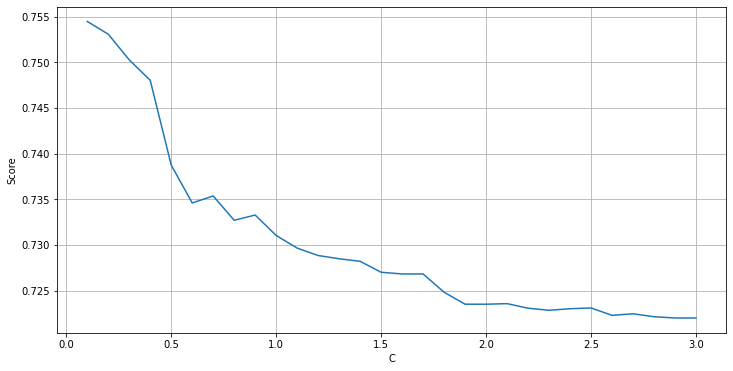

In [58]:
results = pd.DataFrame()
# collect parameter list
results['alpha'] = grid_no_up.cv_results_['param_C'].data
# collect test scores
results['score'] = grid_no_up.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['alpha'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

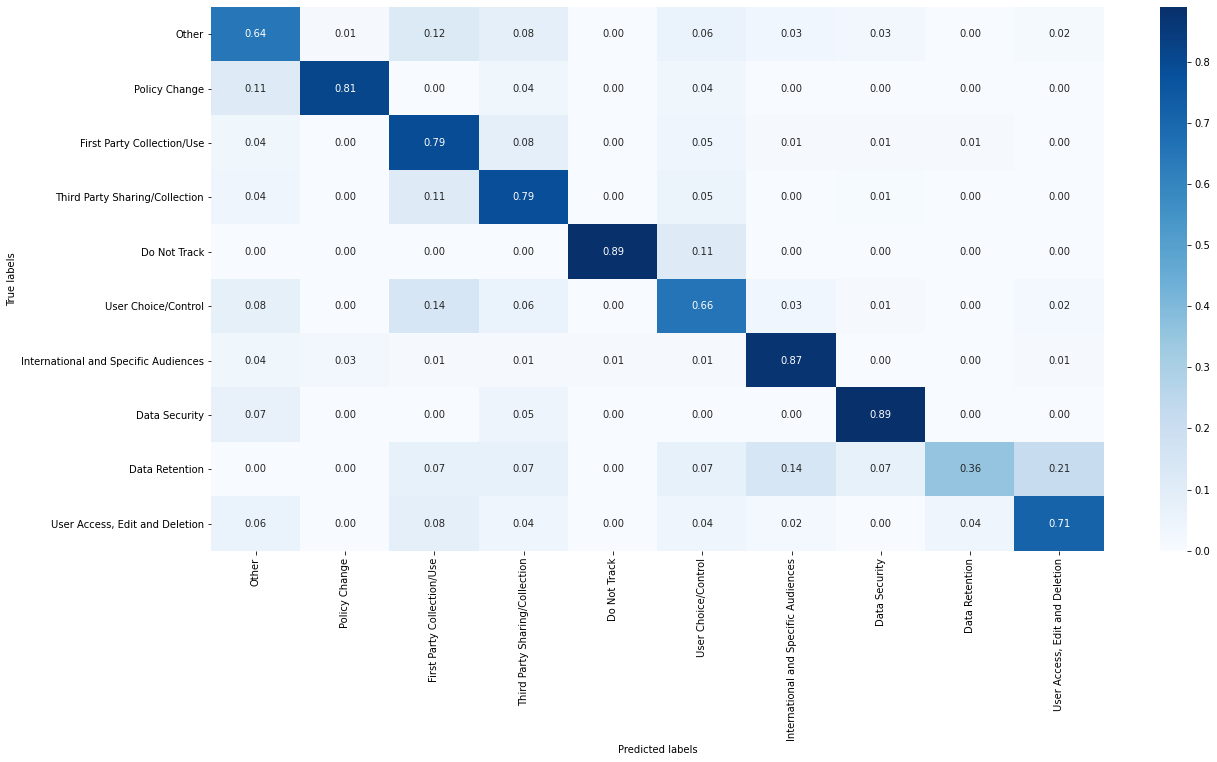

                                      precision    recall  f1-score   support

                      Data Retention       0.45      0.36      0.40        14
                       Data Security       0.71      0.89      0.79        44
                        Do Not Track       0.80      0.89      0.84         9
          First Party Collection/Use       0.77      0.79      0.78       333
International and Specific Audiences       0.78      0.87      0.83        79
                               Other       0.81      0.64      0.72       264
                       Policy Change       0.79      0.81      0.80        27
      Third Party Sharing/Collection       0.75      0.79      0.77       229
      User Access, Edit and Deletion       0.76      0.71      0.74        49
                 User Choice/Control       0.55      0.66      0.60        90

                            accuracy                           0.75      1138
                           macro avg       0.72      0.74     

In [50]:
grid_no_up_preds = grid_no_up.best_estimator_.predict(segments_test)
labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), grid_no_up_preds.astype(str), labels )
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xticklabels([''] + labels, rotation=90)
ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

#Quick diagnostics
print(classification_report(targets_test.astype(str),grid_no_up_preds.astype(str)))

In [53]:
imba_pipeline = make_pipeline(SMOTE(random_state=0), 
                              LinearSVC(random_state=0, class_weight='balanced'))

new_params = {'linearsvc__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='recall_macro').fit(segments_train, targets_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [54]:
print(grid_imba.best_params_)
print(grid_imba.best_score_)

{'linearsvc__C': 0.1}
0.7478375764587749


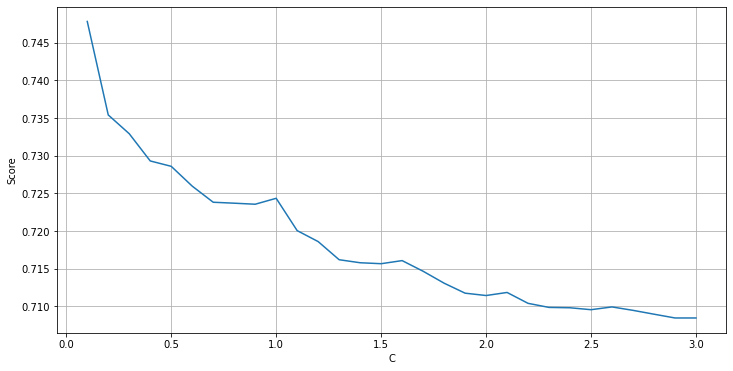

In [55]:
results = pd.DataFrame()
# collect alpha list
results['C'] = grid_imba.cv_results_['param_linearsvc__C'].data
# collect test scores
results['score'] = grid_imba.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['C'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

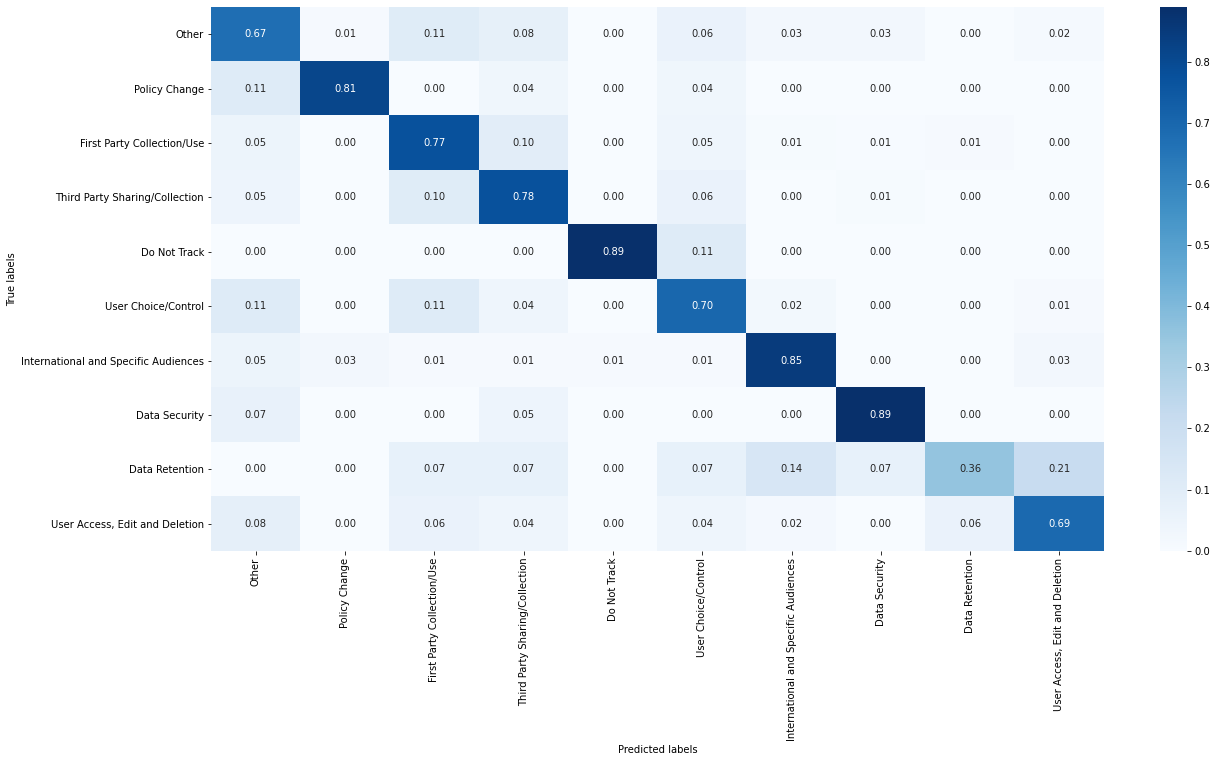

In [56]:
grid_imba_preds = grid_imba.best_estimator_.named_steps['linearsvc'].predict(segments_test)
labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), grid_imba_preds.astype(str), labels )
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xticklabels([''] + labels, rotation=90)
ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [57]:
#Quick diagnostics
print(classification_report(targets_test.astype(str),grid_imba_preds.astype(str)))

                                      precision    recall  f1-score   support

                      Data Retention       0.42      0.36      0.38        14
                       Data Security       0.76      0.89      0.82        44
                        Do Not Track       0.80      0.89      0.84         9
          First Party Collection/Use       0.79      0.77      0.78       333
International and Specific Audiences       0.82      0.85      0.83        79
                               Other       0.77      0.67      0.72       264
                       Policy Change       0.81      0.81      0.81        27
      Third Party Sharing/Collection       0.74      0.78      0.76       229
      User Access, Edit and Deletion       0.76      0.69      0.72        49
                 User Choice/Control       0.55      0.70      0.62        90

                            accuracy                           0.75      1138
                           macro avg       0.72      0.74     

In [ ]:
smote = SMOTE('minority', random_state=0)
segments_smote, targets_smote = smote.fit_sample(segments_train, targets_train)

for i in range(8):
  segments_smote, targets_smote = smote.fit_sample(segments_smote, targets_smote)
smote_df = pd.concat([pd.DataFrame(segments_smote, columns=feature_names), pd.DataFrame(targets_smote, columns=['output'])], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
smote_df['output'].value_counts()

International and Specific Audiences    795
Data Retention                          795
User Choice/Control                     795
Do Not Track                            795
Other                                   795
User Access, Edit and Deletion          795
Policy Change                           795
First Party Collection/Use              795
Data Security                           795
Third Party Sharing/Collection          795
Name: output, dtype: int64

In [ ]:
#paramater selection
start_time = time.time()

parameters = [{'C': [0.001, 0.01, 0.1, 1, 10],
              'degree': [2, 3, 4],
              'kernel': ['rbf', 'poly', 'sigmoid'],
              'gamma':  [0.001, 0.01, 0.1, 1, 10],
              }]

params = {'alpha': alpha_list,
          }

gs_clf = GridSearchCV(classifier, params, n_jobs=-1, cv=kf, verbose=1)
gs_clf = gs_clf.fit(smote_df[feature_names],smote_df['output'])
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')
print("Best parameter: ",gs_clf.best_params_)
print("Best score: ",gs_clf.best_score_) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   43.1s finished


Done training in 43.55330038070679 seconds.
Best parameter:  {'alpha': 0.1}
Best score:  0.8742138364779874


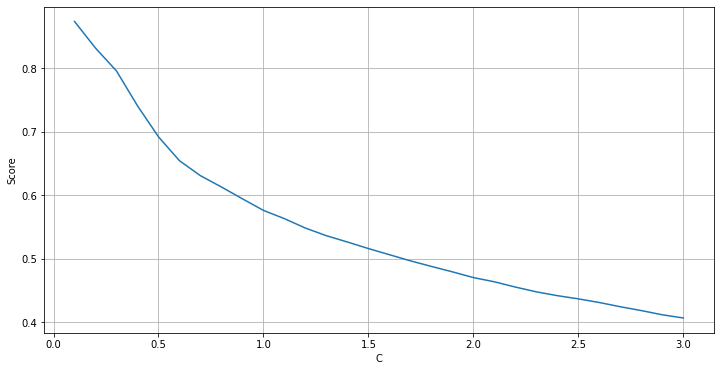

In [ ]:
results = pd.DataFrame()
# collect alpha list
results['C'] = gs_clf.cv_results_['param_alpha'].data
# collect test scores
results['score'] = gs_clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['C'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

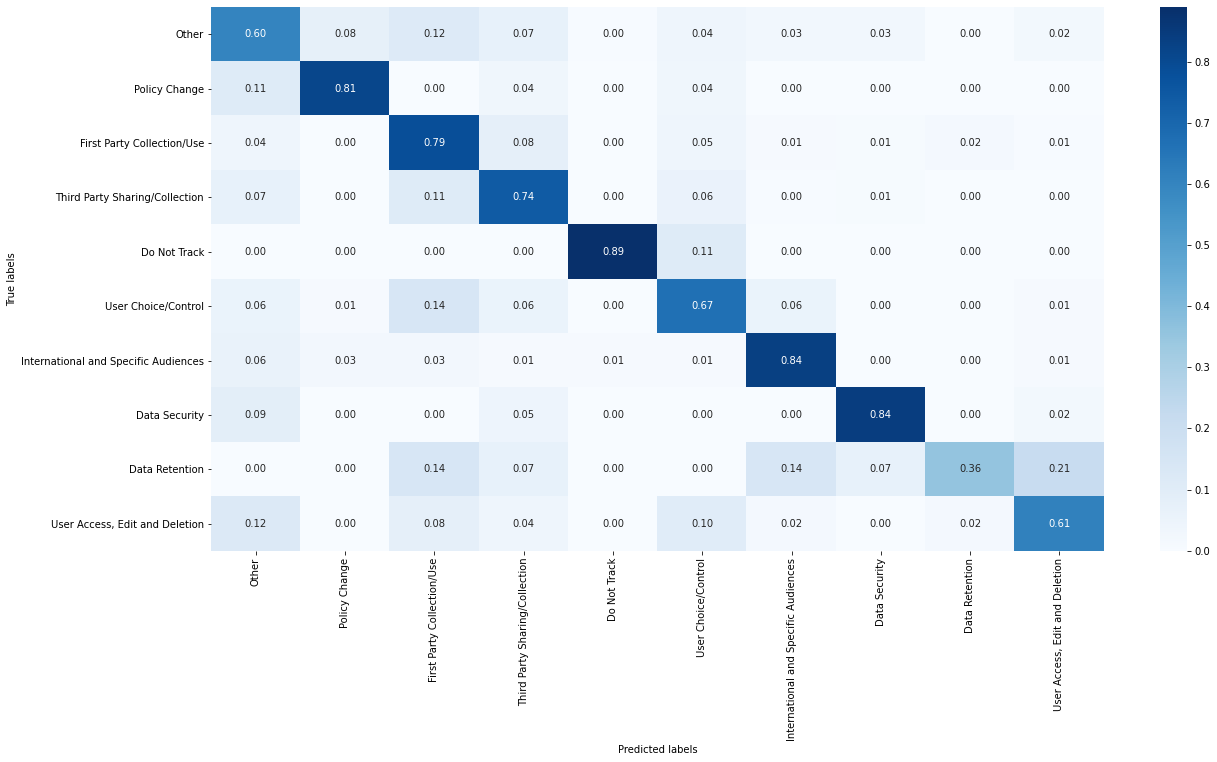

In [ ]:
preds = gs_clf.predict(segments_test)
labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), preds.astype(str), labels )
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
ax.set_xticklabels([''] + labels, rotation=90)
ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [ ]:
#Quick diagnostics
print(classification_report(targets_test.astype(str),preds.astype(str)))

                                      precision    recall  f1-score   support

                      Data Retention       0.42      0.36      0.38        14
                       Data Security       0.73      0.84      0.78        44
                        Do Not Track       0.73      0.89      0.80         9
          First Party Collection/Use       0.77      0.79      0.78       333
International and Specific Audiences       0.76      0.84      0.80        79
                               Other       0.75      0.60      0.67       264
                       Policy Change       0.48      0.81      0.60        27
      Third Party Sharing/Collection       0.75      0.74      0.74       229
      User Access, Edit and Deletion       0.68      0.61      0.65        49
                 User Choice/Control       0.56      0.67      0.61        90

                            accuracy                           0.72      1138
                           macro avg       0.66      0.71     